This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [183]:
!pip install keras keras-hub --upgrade -q

In [184]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [185]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Introduction to TensorFlow, PyTorch, JAX, and Keras

### A brief history of deep learning frameworks

### How these frameworks relate to each other

### Introduction to TensorFlow

#### First steps with TensorFlow

##### Tensors and variables in TensorFlow

###### Constant tensors

In [186]:
import tensorflow as tf
tf.ones(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [187]:
tf.zeros(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

In [188]:
tf.constant([1, 2, 3], dtype="float32")

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

###### Random tensors

In [189]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[ 0.46913192]
 [-1.1001772 ]
 [-0.86459315]], shape=(3, 1), dtype=float32)


In [190]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.30727494]
 [0.04320705]
 [0.01983225]], shape=(3, 1), dtype=float32)


###### Tensor assignment and the Variable class

In [191]:
import numpy as np

x = np.ones(shape=(2, 2))
x[0, 0] = 0.0

In [192]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.09325636],
       [ 0.02767283],
       [-1.5760221 ]], dtype=float32)>


In [193]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [194]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [195]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

##### Tensor operations: Doing math in TensorFlow

In [196]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
f = tf.concat((a, b), axis=0)

In [197]:
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

##### Gradients in TensorFlow: A second look at the GradientTape API

In [198]:
input_var = tf.Variable(initial_value=3.0)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

In [199]:
input_const = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

In [200]:
time = tf.Variable(0.0)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time**2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

##### Making TensorFlow functions fast using compilation

In [201]:
@tf.function
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

In [202]:
@tf.function(jit_compile=True)
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

#### An end-to-end example: A linear classifier in pure TensorFlow

In [203]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)

In [204]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [205]:
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32"),
    )
)

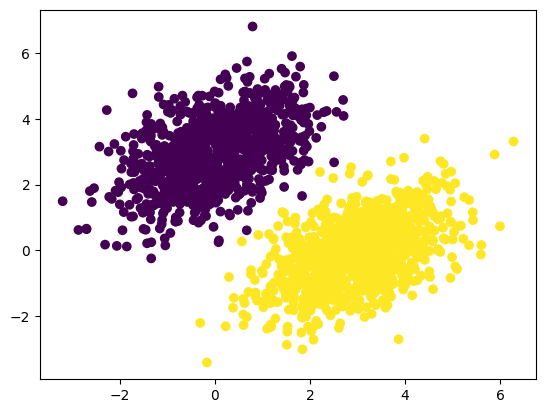

In [206]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [207]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [208]:
def model(inputs, W, b):
    return tf.matmul(inputs, W) + b

In [209]:
def mean_squared_error(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [210]:
learning_rate = 0.1

@tf.function(jit_compile=True)
def training_step(inputs, targets, W, b):
    with tf.GradientTape() as tape:
        predictions = model(inputs, W, b)
        loss = mean_squared_error(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [211]:
for step in range(40):
    loss = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 8.1334
Loss at step 1: 0.9498
Loss at step 2: 0.2569
Loss at step 3: 0.1768
Loss at step 4: 0.1576
Loss at step 5: 0.1453
Loss at step 6: 0.1346
Loss at step 7: 0.1250
Loss at step 8: 0.1161
Loss at step 9: 0.1081
Loss at step 10: 0.1008
Loss at step 11: 0.0941
Loss at step 12: 0.0880
Loss at step 13: 0.0825
Loss at step 14: 0.0774
Loss at step 15: 0.0728
Loss at step 16: 0.0686
Loss at step 17: 0.0647
Loss at step 18: 0.0612
Loss at step 19: 0.0581
Loss at step 20: 0.0552
Loss at step 21: 0.0525
Loss at step 22: 0.0501
Loss at step 23: 0.0479
Loss at step 24: 0.0459
Loss at step 25: 0.0441
Loss at step 26: 0.0424
Loss at step 27: 0.0409
Loss at step 28: 0.0395
Loss at step 29: 0.0382
Loss at step 30: 0.0371
Loss at step 31: 0.0360
Loss at step 32: 0.0351
Loss at step 33: 0.0342
Loss at step 34: 0.0334
Loss at step 35: 0.0327
Loss at step 36: 0.0320
Loss at step 37: 0.0314
Loss at step 38: 0.0309
Loss at step 39: 0.0304


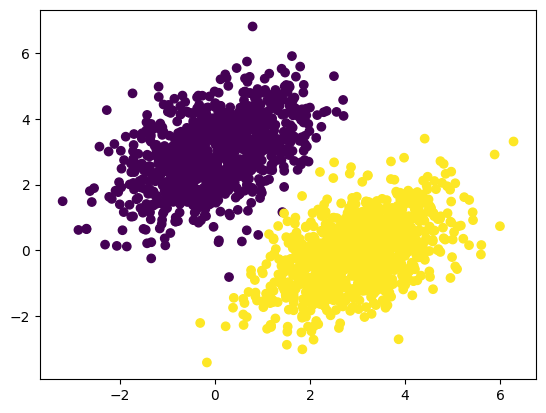

In [212]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

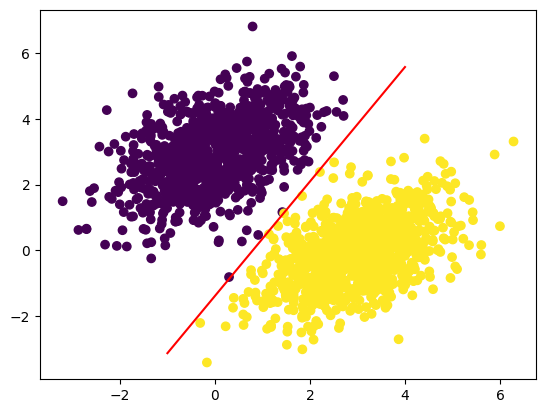

In [213]:
x = np.linspace(-1, 4, 100)
y = -W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

#### What makes the TensorFlow approach unique

### Introduction to PyTorch

#### First steps with PyTorch

##### Tensors and parameters in PyTorch

###### Constant tensors

In [214]:
import torch
torch.ones(size=(2, 1))

tensor([[1.],
        [1.]])

In [215]:
torch.zeros(size=(2, 1))

tensor([[0.],
        [0.]])

In [216]:
torch.tensor([1, 2, 3], dtype=torch.float32)

tensor([1., 2., 3.])

###### Random tensors

In [217]:
torch.normal(
mean=torch.zeros(size=(3, 1)),
std=torch.ones(size=(3, 1)))

tensor([[-0.3129],
        [-1.0847],
        [-0.4854]])

In [218]:
torch.rand(3, 1)

tensor([[0.0604],
        [0.3696],
        [0.0851]])

###### Tensor assignment and the Parameter class

In [219]:
x = torch.zeros(size=(2, 1))
x[0, 0] = 1.
x

tensor([[1.],
        [0.]])

In [220]:
x = torch.zeros(size=(2, 1))
p = torch.nn.parameter.Parameter(data=x)

##### Tensor operations: Doing math in PyTorch

In [221]:
a = torch.ones((2, 2))
b = torch.square(a)
c = torch.sqrt(a)
d = b + c
e = torch.matmul(a, b)
f = torch.cat((a, b), dim=0)

In [222]:
def dense(inputs, W, b):
    return torch.nn.relu(torch.matmul(inputs, W) + b)

##### Computing gradients with PyTorch

In [223]:
input_var = torch.tensor(3.0, requires_grad=True)
result = torch.square(input_var)
result.backward()
gradient = input_var.grad
gradient

tensor(6.)

In [224]:
result = torch.square(input_var)
result.backward()
input_var.grad

tensor(12.)

In [225]:
input_var.grad = None

#### An end-to-end example: A linear classifier in pure PyTorch

In [226]:
input_dim = 2
output_dim = 1

W = torch.rand(input_dim, output_dim, requires_grad=True)
b = torch.zeros(output_dim, requires_grad=True)

In [227]:
def model(inputs, W, b):
    return torch.matmul(inputs, W) + b

In [228]:
def mean_squared_error(targets, predictions):
    per_sample_losses = torch.square(targets - predictions)
    return torch.mean(per_sample_losses)

In [229]:
learning_rate = 0.1

def training_step(inputs, targets, W, b):
    predictions = model(inputs)
    loss = mean_squared_error(targets, predictions)
    loss.backward()
    grad_loss_wrt_W, grad_loss_wrt_b = W.grad, b.grad
    with torch.no_grad():
        W -= grad_loss_wrt_W * learning_rate
        b -= grad_loss_wrt_b * learning_rate
    W.grad = None
    b.grad = None
    return loss

##### Packaging state and computation with the Module class

In [230]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand(input_dim, output_dim))
        self.b = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, inputs):
        return torch.matmul(inputs, self.W) + self.b

In [231]:
model = LinearModel()

In [232]:
torch_inputs = torch.tensor(inputs)
output = model(torch_inputs)

In [233]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [234]:
def training_step(inputs, targets):
    predictions = model(inputs)
    loss = mean_squared_error(targets, predictions)
    loss.backward()
    optimizer.step()
    model.zero_grad()
    return loss

##### Making PyTorch modules fast using compilation

In [235]:
compiled_model = torch.compile(model)

In [236]:
@torch.compile
def dense(inputs, W, b):
    return torch.nn.relu(torch.matmul(inputs, W) + b)

#### What makes the PyTorch approach unique

### Introduction to JAX

#### First steps with JAX

#### Tensors in JAX

In [237]:
from jax import numpy as jnp
jnp.ones(shape=(2, 1))

Array([[1.],
       [1.]], dtype=float32)

In [238]:
jnp.zeros(shape=(2, 1))

Array([[0.],
       [0.]], dtype=float32)

In [239]:
jnp.array([1, 2, 3], dtype="float32")

Array([1., 2., 3.], dtype=float32)

#### Random number generation in JAX

In [240]:
np.random.normal(size=(3,))

array([ 0.10745759, -0.41253767, -0.57231418])

In [241]:
np.random.normal(size=(3,))

array([ 0.55662363,  0.62097863, -0.41971819])

In [242]:
def apply_noise(x, seed):
    np.random.seed(seed)
    x = x * np.random.normal((3,))
    return x

seed = 1337
y = apply_noise(x, seed)
seed += 1
z = apply_noise(x, seed)

/tmp/ipython-input-2654806653.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = x * np.random.normal((3,))


In [243]:
import jax

seed_key = jax.random.key(1337)

In [244]:
seed_key = jax.random.key(0)
jax.random.normal(seed_key, shape=(3,))

Array([ 1.6226422 ,  2.0252647 , -0.43359444], dtype=float32)

In [245]:
seed_key = jax.random.key(123)
jax.random.normal(seed_key, shape=(3,))

Array([1.6359469 , 0.8408094 , 0.02212393], dtype=float32)

In [246]:
jax.random.normal(seed_key, shape=(3,))

Array([1.6359469 , 0.8408094 , 0.02212393], dtype=float32)

In [247]:
seed_key = jax.random.key(123)
jax.random.normal(seed_key, shape=(3,))

Array([1.6359469 , 0.8408094 , 0.02212393], dtype=float32)

In [248]:
new_seed_key = jax.random.split(seed_key, num=1)[0]
jax.random.normal(new_seed_key, shape=(3,))

Array([-0.49093357, -0.9478693 , -1.775197  ], dtype=float32)

##### Tensor assignment

In [249]:
x = jnp.array([1, 2, 3], dtype="float32")
new_x = x.at[0].set(10)

##### Tensor operations: Doing math in JAX

In [250]:
a = jnp.ones((2, 2))
b = jnp.square(a)
c = jnp.sqrt(a)
d = b + c
e = jnp.matmul(a, b)
e *= d

In [251]:
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

##### Computing gradients with JAX

In [252]:
def compute_loss(input_var):
    return jnp.square(input_var)

In [253]:
grad_fn = jax.grad(compute_loss)

In [254]:
input_var = jnp.array(3.0)
grad_of_loss_wrt_input_var = grad_fn(input_var)

##### JAX gradient-computation best practices

###### Returning the loss value

In [255]:
grad_fn = jax.value_and_grad(compute_loss)
output, grad_of_loss_wrt_input_var = grad_fn(input_var)

###### Getting gradients for a complex function

###### Returning auxiliary outputs

##### Making JAX functions fast with @jax.jit

In [256]:
@jax.jit
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

#### An end-to-end example: A linear classifier in pure JAX

In [257]:
def model(inputs, W, b):
    return jnp.matmul(inputs, W) + b

def mean_squared_error(targets, predictions):
    per_sample_losses = jnp.square(targets - predictions)
    return jnp.mean(per_sample_losses)

In [258]:
def compute_loss(state, inputs, targets):
    W, b = state
    predictions = model(inputs, W, b)
    loss = mean_squared_error(targets, predictions)
    return loss

In [259]:
grad_fn = jax.value_and_grad(compute_loss)

In [260]:
learning_rate = 0.1

@jax.jit
def training_step(inputs, targets, W, b):
    loss, grads = grad_fn((W, b), inputs, targets)
    grad_wrt_W, grad_wrt_b = grads
    W = W - grad_wrt_W * learning_rate
    b = b - grad_wrt_b * learning_rate
    return loss, W, b

In [261]:
input_dim = 2
output_dim = 1

W = jax.numpy.array(np.random.uniform(size=(input_dim, output_dim)))
b = jax.numpy.array(np.zeros(shape=(output_dim,)))
state = (W, b)
for step in range(40):
    loss, W, b = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.5109
Loss at step 1: 0.1935
Loss at step 2: 0.1109
Loss at step 3: 0.0968
Loss at step 4: 0.0898
Loss at step 5: 0.0841
Loss at step 6: 0.0789
Loss at step 7: 0.0741
Loss at step 8: 0.0698
Loss at step 9: 0.0659
Loss at step 10: 0.0623
Loss at step 11: 0.0590
Loss at step 12: 0.0560
Loss at step 13: 0.0533
Loss at step 14: 0.0508
Loss at step 15: 0.0485
Loss at step 16: 0.0465
Loss at step 17: 0.0446
Loss at step 18: 0.0429
Loss at step 19: 0.0413
Loss at step 20: 0.0399
Loss at step 21: 0.0386
Loss at step 22: 0.0374
Loss at step 23: 0.0363
Loss at step 24: 0.0354
Loss at step 25: 0.0345
Loss at step 26: 0.0336
Loss at step 27: 0.0329
Loss at step 28: 0.0322
Loss at step 29: 0.0316
Loss at step 30: 0.0310
Loss at step 31: 0.0305
Loss at step 32: 0.0300
Loss at step 33: 0.0296
Loss at step 34: 0.0292
Loss at step 35: 0.0289
Loss at step 36: 0.0285
Loss at step 37: 0.0283
Loss at step 38: 0.0280
Loss at step 39: 0.0277


#### What makes the JAX approach unique

### Introduction to Keras

#### First steps with Keras

##### Picking a backend framework

In [262]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import keras

#### Layers: The building blocks of deep learning

##### The base `Layer` class in Keras

In [263]:
import keras

class SimpleDense(keras.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        batch_dim, input_dim = input_shape
        self.W = self.add_weight(
            shape=(input_dim, self.units), initializer="random_normal"
        )
        self.b = self.add_weight(shape=(self.units,), initializer="zeros")

    def call(self, inputs):
        y = keras.ops.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [264]:
my_dense = SimpleDense(units=32, activation=keras.ops.relu)
input_tensor = keras.ops.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


##### Automatic shape inference: Building layers on the fly

In [265]:
from keras import layers

layer = layers.Dense(32, activation="relu")

In [266]:
from keras import models
from keras import layers

model = models.Sequential(
    [
        layers.Dense(32, activation="relu"),
        layers.Dense(32),
    ]
)

In [267]:
model = keras.Sequential(
    [
        SimpleDense(32, activation="relu"),
        SimpleDense(64, activation="relu"),
        SimpleDense(32, activation="relu"),
        SimpleDense(10, activation="softmax"),
    ]
)

#### From layers to models

#### The "compile" step: Configuring the learning process

In [268]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    optimizer="rmsprop",
    loss="mean_squared_error",
    metrics=["accuracy"],
)

In [269]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

#### Picking a loss function

#### Understanding the fit method

In [270]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128,
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.3260 - loss: 2.3916
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3215 - loss: 2.2343
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3210 - loss: 2.1052
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3225 - loss: 1.9840
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3235 - loss: 1.8656


In [271]:
history.history

{'binary_accuracy': [0.32600000500679016,
  0.3215000033378601,
  0.32100000977516174,
  0.3225000202655792,
  0.32350000739097595],
 'loss': [2.3916118144989014,
  2.2343039512634277,
  2.105222225189209,
  1.9840022325515747,
  1.8655964136123657]}

#### Monitoring loss and metrics on validation data

In [272]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets),
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9493 - loss: 0.0825 - val_binary_accuracy: 0.9200 - val_loss: 0.1593
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9564 - loss: 0.0728 - val_binary_accuracy: 0.9933 - val_loss: 0.0670
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9536 - loss: 0.0778 - val_binary_accuracy: 0.9967 - val_loss: 0.0350
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9636 - loss: 0.0710 - val_binary_accuracy: 0.8800 - val_loss: 0.1470
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9614 - loss: 0.0724 - val_binary_accuracy: 0.9867 - val_loss: 0.0510


#### Inference: Using a model after training

In [273]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[1.0038759 ]
 [0.21569672]
 [0.91350913]
 [0.36143628]
 [0.9609965 ]
 [0.3885958 ]
 [0.86927146]
 [0.9796995 ]
 [0.83454835]
 [0.18922004]]
